In [1]:
%matplotlib notebook

In [2]:
import os
import sys
import cv2
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
src_dir = os.path.join("../src")
sys.path.insert(0, src_dir)
from dataloader import FrameDataLoader, FrameDataLoaderTF
from dataloader.transform import *

img = cv2.imread('../data/anonymisedVideos/-43p5IQaY18_000383_000393_0.jpg')
imgs = np.expand_dims(img, axis=0) 

# B, H, W, C
frames = np.transpose(imgs, (0, 3, 1, 2))
Image.fromarray(img)

img_shape = frames.shape
resize_factor = random.uniform(0.8, 1.2)
resized = np.zeros((1, img_shape[1], int(img_shape[2]*resize_factor), int(img_shape[3]*resize_factor)))
for n, i in enumerate(frames):
    resized[n, :, :, :] = resize(
        frames[n, :, :, :], resized.shape[1:], anti_aliasing=True)
frames = resized
frames.shape

res = np.transpose(frames, (0, 2, 3, 1))
Image.fromarray((res[0]*255).astype(np.uint8))

with open("../data/anonymisedVideos/types.json", "r") as f:
    cls_types = json.load(f)
labels = pd.read_csv('../data/anonymisedVideos/videos.csv', index_col="name")

def get_start_end_idx(video_size, clip_size, clip_idx, num_clips):
    delta = max(video_size - clip_size, 0)
    start_idx = delta * clip_idx / num_clips
    end_idx = start_idx + clip_size - 1
    return start_idx, end_idx

file_list = list(Path("../data/anonymisedVideos").glob("*.jpg"))
temp_files = dict(zip(map(lambda x: x.stem, file_list),
                map(lambda x: str(x), file_list)))

files = {}
for (k, v) in temp_files.items():
    ksplit = k.split("_")
    video_name, frame_id = "_".join(ksplit[:-1]), int(ksplit[-1])
    if not video_name in files:
        files[video_name] = {}
    files[video_name][frame_id] = v

temp_files = {}
for k in files.keys():
    files[k] = sorted(files[k].items())
    video_fps = int(labels.loc[k]['fps'])
    video_size = len(files[k])
    if(video_size > 12 * video_fps):
        split_num = video_size // (12 * video_fps)
        for x in range(0, split_num+1):
            start_idx, end_idx = get_start_end_idx(video_size, 12 * video_fps, x, split_num)
            temp_files["%s/%d"%(k, x)] = files[k][round(start_idx):round(end_idx)]
    else:
        temp_files[k] = files[k]
files = collections.OrderedDict(temp_files)

In [3]:
def anim(a_batch, label):
    fig, ax = plt.subplots()
    anim_res = []
    imgs = a_batch.transpose((1,2,3,0))
    for i in range(imgs.shape[0]):
        ax.set_title(label)
        anim_res.append([ax.imshow(Image.fromarray(imgs[i]), animated=True)])
    return animation.ArtistAnimation(fig, anim_res, interval=100, blit=True, repeat_delay=1000)

In [4]:
batch_size = 3
ds = FrameDataLoaderTF("../data/anonymisedVideos", 15, 5, 10, resolution=[224, 224], batch_size=batch_size, shuffle=True)
print(ds.__len__())

496


2021-07-17 11:39:41.346234: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
if ds.hasSplitValidation():
    train_ds, val_ds = ds.getSplitDataset()
    print("Train len:", ds.getTrainLen(), ", Val len: ", ds.getValLen())
iter = iter(val_ds)
# for i in range(46):
X, frame_idx, y = next(iter)
print(X.shape, frame_idx, y)

2021-07-17 11:39:41.484117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Train len: 447 , Val len:  49


2021-07-17 11:39:53.265289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 2 of 6
2021-07-17 11:40:01.964331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 3 of 6


(3, 3, 15, 224, 224) tf.Tensor(
[[ 52  61  69  78  87  96 105 114 123 131 140 149 158 167 176]
 [ 34  43  52  61  70  79  87  96 105 114 123 132 141 149 158]
 [121 130 139 148 157 166 174 183 192 201 210 219 228 236 245]], shape=(3, 15), dtype=int32) tf.Tensor([2 2 2], shape=(3,), dtype=int32)


2021-07-17 11:40:11.469480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


In [6]:
X, frame_idx, y = next(iter)

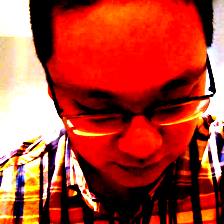

In [7]:
img = (X[0].numpy()*255).astype(np.uint8)
img = img.transpose((1,2,3,0))[0]
Image.fromarray(img)

In [9]:
HTML(anim((X[0].numpy()*255).astype(np.uint8), y[0].numpy()).to_jshtml())

<IPython.core.display.Javascript object>